In [1]:
import pandas as pd
import numpy as np
import openpyxl 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

### Metabolic profile of Acute toxicity data

In [3]:
times = pd.read_excel(external_dir/'smi_acute_ivt_metab.xlsx')

In [4]:
times.head()


times = (times
         .assign(Parent = lambda x: x['Chemical name'].ffill())
 .assign(Parent_id = lambda df: df['Chemical name'].apply(
        lambda x: 'Parent' if isinstance(x, str)  else x
    ))
)

In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import networkx as nx

In [6]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key

In [7]:
newlst = []

# Sort the DataFrame by 'Parent' and any other relevant column, such as 'Level of generation'
times = times.sort_values(by=['Parent', 'Level of generation']).reset_index(drop=True)

# Iterate over each group
for i, group in times.groupby('Parent'):
    subset = group[['Parent', 'Parent_id']]
    # Define a counter for generating unique identifiers
    counter = 1
    # Iterate over rows in the subset
    for index, row in subset.iterrows():
        if row['Parent_id'] == 'Parent':
            newlst.append(row['Parent'])  # Use the parent ID as is
        else:
            # Append with a unique identifier based on the counter
            newlst.append(row['Parent'] + '_m_' + str(counter))
            # Increment the counter
            counter += 1


In [8]:
len(newlst)

88962

In [9]:
times.shape

(88962, 22)

In [10]:
times['ID'] = newlst

In [11]:
inchi_keys = {}
errors = []
for k,v in zip(times['ID'], times['SMILES']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        inchi_keys[k] = X

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefined stereo

[17:14:07] WARNING: Omitted undefi

In [12]:
df_inchi = pd.DataFrame(inchi_keys.items(), columns = ['ID', 'INCHI_KEY'])

In [13]:
times = pd.merge(times, df_inchi, on = 'ID', how = 'left')

In [14]:
times[['ID of metabolite', 'Level of generation', 'Predecessor ID','Chemical name', 'SMILES','Parent', 'ID']].head()

,ID of metabolite,Level of generation,Predecessor ID,Chemical name,SMILES,Parent,ID
0,1,0,-,DTXSID00142939,CC(=O)OCC#N,DTXSID00142939,DTXSID00142939
1,2,1,1,NaN,CC(O)=O,DTXSID00142939,DTXSID00142939_m_1
2,3,1,1,NaN,N#CCO,DTXSID00142939,DTXSID00142939_m_2
3,4,2,3,NaN,C=O,DTXSID00142939,DTXSID00142939_m_3
4,5,2,3,NaN,C#N,DTXSID00142939,DTXSID00142939_m_4


In [15]:
times1 = (times
 .rename(columns=lambda col: col.replace(' ', '_'))
 .assign(transformation = lambda df : df['Transformation_name'].apply(
        lambda x: x.split('|')[0] if isinstance(x, str) and '|' in x else x
    )) 
 .filter(items = ['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',  'Chemical_name', 'SMILES',  'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation'])
)

In [16]:
times1['mol'] = [Chem.MolFromSmiles(e) for e in times1['SMILES']]

[17:14:58] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:14:59] SMILES Parse Error: syntax error while parsing: C[C.](C)C#N
[17:14:59] SMILES Parse Error: Failed parsing SMILES 'C[C.](C)C#N' for input: 'C[C.](C)C#N'
[17:14:59] SMILES Parse Error: syntax error while parsing: C[C.](C)C#N
[17:14:59] SMILES Parse Error: Failed parsing SMILES 'C[C.](C)C#N' for input: 'C[C.](C)C#N'
[17:15:00] SMILES Parse Error: syntax error while parsing: [C.]OC1C(O)C(O)C(O)C(CO)O1
[17:15:00] SMILES Parse Error: Failed parsing SMILES '[C.]OC1C(O)C(O)C(O)C(CO)O1' for input: '[C.]OC1C(O)C(O)C(O)C(CO)O1'
[17:15:00] SMILES Parse Error: syntax error while parsing: [C.]
[17:15:00] SMILES Parse Error: Failed parsing SMILES '[C.]' for input: '[C.]'
[17:15:00] SMILES Parse Error: syntax error while parsing: [C.]O
[17:15:00] SMILES Parse Error: Failed parsing SMILES '[C.]O' for input: '[C.]O'
[17:15:00] SMILES Parse Error: syntax error while parsing: [C.]
[17:15:00] SMILES Parse Error: Failed pars

In [17]:
from rdkit.Chem import rdFingerprintGenerator

In [18]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=1024)

In [19]:
times1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88962 entries, 0 to 88961
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_of_metabolite     88962 non-null  int64 
 1   Level_of_generation  88962 non-null  int64 
 2   Predecessor_ID       88962 non-null  object
 3   Chemical_name        6474 non-null   object
 4   SMILES               88962 non-null  object
 5   Parent               88962 non-null  object
 6   Parent_id            6474 non-null   object
 7   ID                   88962 non-null  object
 8   INCHI_KEY            88928 non-null  object
 9   transformation       82488 non-null  object
 10  mol                  88928 non-null  object
dtypes: int64(2), object(9)
memory usage: 7.5+ MB


In [20]:
times1 = (times1
 .assign(fps = lambda df: df.apply(lambda row: mfpgen.GetFingerprintAsNumPy(row['mol']) if row['mol'] is not None else np.nan, axis =1)
        )
         )

In [21]:
times1 = (times1
 .filter(['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',
       'Chemical_name', 'SMILES', 'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation', 'mol', 'fps'])
)

In [22]:
times1[times1['fps'].isnull()]['Parent'].unique()

array(['DTXSID0021834', 'DTXSID1026457', 'DTXSID2057574', 'DTXSID3049756',
       'DTXSID7073569', 'DTXSID8027747'], dtype=object)

In [23]:
times1 = (times1
 .query("Parent not in ['DTXSID0021834', 'DTXSID1026457', 'DTXSID2057574', 'DTXSID3049756','DTXSID7073569', 'DTXSID8027747']")
       )

In [24]:
transformation_types = times1['transformation'].unique().tolist()
transformation_types = transformation_types[1:]
edges = times1[times1['Predecessor_ID'] != '-']

In [25]:
transformation_index = {t: i for i, t in enumerate(transformation_types)}

In [26]:
n_transformations = len(transformation_types)

In [27]:
n_transformations

85

In [28]:
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

In [29]:
def create_node_label(row):
    # Concatenate the desired columns for more expressive labels
    return f"ID: {row['ID']}"

In [30]:
groups = times1.groupby('Parent')

# Initialize a dictionary to store graphs
graph_dict = {}
for parent, group in groups:
    # Initialize a directed graph for this parent
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in group.iterrows():
        label = create_node_label(row)
        G.add_node(
            row['ID_of_metabolite'],
            chemical_name=row['Chemical_name'],
            SMILES=row['SMILES'],
            label=label,
            fingerprint=row['fps'],
            ID = row['ID']
        )
    
    # Add edges with sparse one-hot encoded transformation types
    for _, row in group.iterrows():
        if row['Predecessor_ID'] != '-':  # Skip root nodes without predecessors
            transformation_type = row['transformation']  # Define this logic
            index = transformation_index[transformation_type]
            
            # Create sparse one-hot encoding for the edge
            sparse_vector = lil_matrix((1, n_transformations))
            sparse_vector[0, index] = 1
            
            G.add_edge(
                row['Predecessor_ID'],
                row['ID_of_metabolite'],
                transformation_type=transformation_type,
                sparse_one_hot=sparse_vector
            )
    
    # Store the graph with the Parent as the key
    graph_dict[parent] = G

In [33]:
graph_dict['DTXSID00142939']

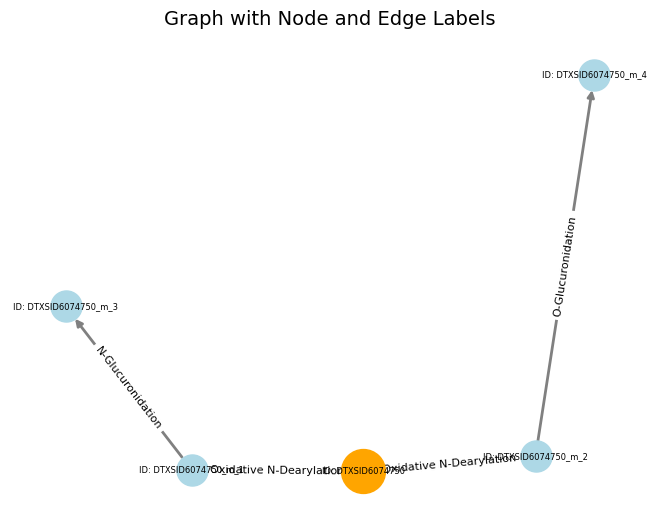

In [34]:
parent_id = "DTXSID6074750"
G = graph_dict[parent_id]


pos = nx.spring_layout(G, k=0.5, seed=42)
# Visualize the graph (optional)
nx.draw(
    G, pos, with_labels=False, node_color='lightblue', node_size=500, font_size=6, edge_color='gray', width=2
)

# Draw node labels using a 'label' attribute
node_labels = nx.get_node_attributes(G, 'label')  # Ensure nodes have a 'label' attribute
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6)

# Draw edge labels (ensure edges have a 'transformation_type' or similar attribute)
edge_labels = nx.get_edge_attributes(G, 'transformation_type')  # Ensure edges have this attribute
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

# Make parent nodes stand out (e.g., larger size, different color)
parent_nodes = [node for node, label in node_labels.items() if '_m_' not in label]# Identify parent nodes by condition
nx.draw_networkx_nodes(G, pos, nodelist=parent_nodes, node_color='orange', node_size=1000)

# Optionally, adjust layout with more manual control to avoid overlap
# You can tweak 'pos' manually if you know the specific positions
# Example: pos['Parent'] = [0, 0]  # This sets the 'Parent' node to the center

plt.title("Graph with Node and Edge Labels", fontsize=14)
plt.axis('off')  # Turn off the axis to make the graph clearer
plt.show()



In [35]:
len(graph_dict.keys())

6468

In [36]:
ids = list(graph_dict.keys())

In [37]:
acute = pd.read_csv(external_dir/'small_acute_processed.csv')

In [38]:
acute = (acute
 .rename(columns = {'dsstox_sid': 'dtxsid'})
 .query("dtxsid  in @ids")
)

In [39]:
acute.head(1)

,dtxsid,very_toxic,nontoxic,LD50_mgkg,EPA_category,GHS_category,casrn,mol_weight,LD50_LM
0,DTXSID5020281,False,False,460.0,2.0,4.0,100-00-5,157.550003,-0.465339


In [40]:
acute.shape

(6468, 9)

In [42]:
import torch
from torch_geometric.data import Data, Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss,BCELoss
from torch_geometric.nn import GCNConv,GATv2Conv,global_mean_pool

In [43]:
def convert_nx_to_pyg(G):
    """
    Converts a NetworkX graph G into a PyTorch Geometric Data object.
    
    Args:
        G (networkx.DiGraph): The input metabolic graph.
        endpoint_df (pd.DataFrame): A DataFrame containing 'ID' and 'endpoint_label' for nodes.

    Returns:
        Data: PyTorch Geometric Data object
    """
    node_ids = list(G.nodes)
    id_map = {node_id: i for i, node_id in enumerate(node_ids)}

    # Extract node features and attributes
    node_features = []
    node_chemical_names = []
    node_SMILES = []
    

    for n in node_ids:
        fingerprint_vector = G.nodes[n]['fingerprint'].flatten()
        node_features.append(fingerprint_vector)

        node_chemical_names.append(G.nodes[n]['chemical_name'])
        node_SMILES.append(G.nodes[n]['SMILES'])

        
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Extract edges
    edge_index = []
    edge_features = []
    edge_types = []  # For debugging

    for source, target, data in G.edges(data=True):
        edge_index.append([id_map[source], id_map[target]])

        # Convert sparse one-hot encoding to dense tensor
        sparse_one_hot = data['sparse_one_hot'].toarray().flatten()
        edge_features.append(sparse_one_hot)

        # Store edge transformation type
        edge_types.append(data['transformation_type'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create PyG Data object with extra attributes stored as lists
    return Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
        chemical_name=node_chemical_names,
        edge_types=edge_types
    )


In [98]:
class MolDataset(Dataset):
    def __init__(self, df):
        """
        fp1: target column in df of numpy representation of Morgan fp
        fp2: analogue column in df of numpy representation of Morgan fp
        labels: List of 0 (similar) or 1 (dissimilar) for each pair
        """
        self.df = df
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        graph = convert_nx_to_pyg(graph_dict[row['dtxsid']])
        identifier = row['dtxsid']
        graph.y = torch.tensor(row['LD50_LM'], dtype=torch.float32)
        
        return graph

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
acute1 = acute.set_index('dtxsid')

## Quick Baseline

In [47]:
acute_smi = (pd.concat([pd.read_excel(external_dir/'smi_acute.xlsx', sheet_name = 'first'), pd.read_excel(external_dir/'smi_acute.xlsx', sheet_name = 'last')]))

In [48]:
acute_smi = (acute_smi
 .query('QSAR_READY_SMILES.notnull()')
)

In [49]:
acute_smi['mol'] = [Chem.MolFromSmiles(e) for e in acute_smi['QSAR_READY_SMILES']]

In [50]:
acute_smi = (acute_smi
 .assign(fps = lambda df: df.apply(lambda row: mfpgen.GetFingerprintAsNumPy(row['mol']) if row['mol'] is not None else np.nan, axis =1)
        )
         )

In [51]:
acute_smi.columns

Index(['INPUT', 'FOUND_BY', 'DTXSID', 'PREFERRED_NAME', 'SMILES',
       'QSAR_READY_SMILES', 'mol', 'fps'],
      dtype='object')

In [52]:
acute2 = (acute
 .merge(acute_smi[['DTXSID', 'PREFERRED_NAME', 'QSAR_READY_SMILES','fps']], left_on = 'dtxsid', right_on = 'DTXSID', how = 'left')
)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(acute2, acute2['LD50_LM'], test_size = 0.2)

In [99]:
train_data = MolDataset(X_train)

In [100]:
train_data[0]

Data(x=[4, 1024], edge_index=[2, 3], edge_attr=[3, 85], chemical_name=[4], edge_types=[3], y=-0.9823324084281921)

In [101]:
test_data = MolDataset(X_test)

In [102]:
from torch_geometric.loader import DataLoader  # Use this one!

train_loader = DataLoader(train_data, batch_size = 300, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 300, shuffle = False)

In [104]:
train_data[0].num_features

1024

In [105]:
len(train_loader)

18

In [106]:
for batch in train_loader:
    print(type(batch))  # Should output <class 'torch_geometric.data.Batch'>
    print(batch)  # Inspect the structure
    break

<class 'abc.DataBatch'>
DataBatch(x=[4201, 1024], edge_index=[2, 3901], edge_attr=[3901, 85], chemical_name=[300], edge_types=[300], y=[300], batch=[4201], ptr=[301])


In [107]:
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [108]:
embedding_size = 256
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(1024, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Classifier (Linear).
        out = self.out(hidden)

        return out, hidden

In [109]:
model = GCN()
print(model)

GCN(
  (initial_conv): GCNConv(1024, 256)
  (conv1): GCNConv(256, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (out): Linear(in_features=512, out_features=1, bias=True)
)


In [110]:
import warnings
warnings.filterwarnings("ignore")
import time

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [123]:
def train(model, loader):
# Enumerate over the data
    def r2_accuracy(pred_y, y):
        score = r2_score(y, pred_y)
        return round(score, 2)*100
# Root mean squared error
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0007) 


    model.train()
    for data in loader:
    # Reset gradients
        data.to(device)
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        out,embedding = model(data.x,data.edge_index,data.batch)
        
        # Calculating the loss and gradients
        loss = loss_fn(out, data.y)     
        acc = r2_accuracy(out.cpu().detach().numpy(), data.y.cpu().detach().numpy())

        loss.backward()  
    # Update using the gradients
        optimizer.step()   
    return loss, acc, out, data.y, embedding

In [124]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [125]:

epochs = 2000
 


print('\n======== Starting training ... =======\n')
start_time = time.time()
embeddings = []
losses = []
accuracies = []
outputs = []
targets = []

for epoch in range(epochs):
    loss, acc, pred, target, h = train(model, train_loader)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(pred)
    targets.append(target)
    
    if epoch % 100 == 0:
      # print(f"Epoch {epoch} | Train Loss {loss}")
      print(f'Epoch {epoch:>3} | Loss: {loss:.5f} | Acc: {acc:.2f}%')

print("\nTraining done!\n")
elapsed = time.time() - start_time
minutes_e = elapsed//60
print("--- training took:  %s minutes ---" % (minutes_e))


======== Starting training ... =======

Epoch   0 | Loss: 0.67511 | Acc: 0.00%
Epoch 100 | Loss: 0.65615 | Acc: 0.00%
Epoch 200 | Loss: 0.58711 | Acc: -3.00%
Epoch 300 | Loss: 0.73406 | Acc: -0.00%
Epoch 400 | Loss: 0.80043 | Acc: -2.00%
Epoch 500 | Loss: 0.71386 | Acc: -3.00%
Epoch 600 | Loss: 0.67358 | Acc: -5.00%
Epoch 700 | Loss: 0.95590 | Acc: -0.00%
Epoch 800 | Loss: 0.88071 | Acc: -2.00%
Epoch 900 | Loss: 1.22766 | Acc: -2.00%
Epoch 1000 | Loss: 0.76923 | Acc: -0.00%
Epoch 1100 | Loss: 0.86997 | Acc: -3.00%
Epoch 1200 | Loss: 0.80038 | Acc: 0.00%
Epoch 1300 | Loss: 0.62690 | Acc: -0.00%
Epoch 1400 | Loss: 0.51656 | Acc: -10.00%
Epoch 1500 | Loss: 1.07887 | Acc: -1.00%
Epoch 1600 | Loss: 0.52632 | Acc: 0.00%
Epoch 1700 | Loss: 0.65643 | Acc: -2.00%
Epoch 1800 | Loss: 0.91383 | Acc: -0.00%
Epoch 1900 | Loss: 0.66797 | Acc: -0.00%

Training done!

--- training took:  312.0 minutes ---


In [128]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
losses_np = np.array([x.item() for x in losses])
outs = [i[0] for i in outputs]
outputs_np = np.array([x.item() for x in outs])
targs = [i[0] for i in targets]
targets_np = np.array([x.item() for x in targs])

results = pd.concat([pd.DataFrame(losses_np),
                     pd.DataFrame(accuracies),
                     pd.DataFrame(outputs_np),
                     pd.DataFrame(targets_np)], axis= 1)
results.columns = ['losses', 'accuracy', 'pred', 'target']
results.head()

,losses,accuracy,pred,target
0,0.675112,0.0,-0.519313,0.773256
1,0.485574,-6.0,-0.513822,-0.722263
2,0.729343,-1.0,-0.543585,-1.004711
3,0.797614,-2.0,-0.430766,-0.910922
4,0.653043,1.0,-0.531407,-0.411908


In [129]:
# all training
training_acc = r2_accuracy(results["target"], results["pred"])

#first 20 epochs
training_acc_1st_20 = r2_accuracy(results["target"][:20], results["pred"][:20])

# last 20 epochs
training_acc_last_20 = r2_accuracy(results["target"][-20:], results["pred"][-20:])

print("Training accuracy: {}%".format(round(training_acc, 2)))
print("1st 20 Training accuracy: {}%".format(round(training_acc_1st_20, 2)))
print("Last 20 Training accuracy: {}%".format(round(training_acc_last_20, 2)))

Training accuracy: -262627.0%
1st 20 Training accuracy: -87139.0%
Last 20 Training accuracy: -162131.0%


In [130]:
ymin, ymax = np.floor(min(results[[ 'pred', 'target']].min())),\
    round(max(results[[ 'pred', 'target']].max()))

<Axes: title={'center': 'Last 20 epochs\nAccuracy: -162131.0%'}, xlabel='epoch'>

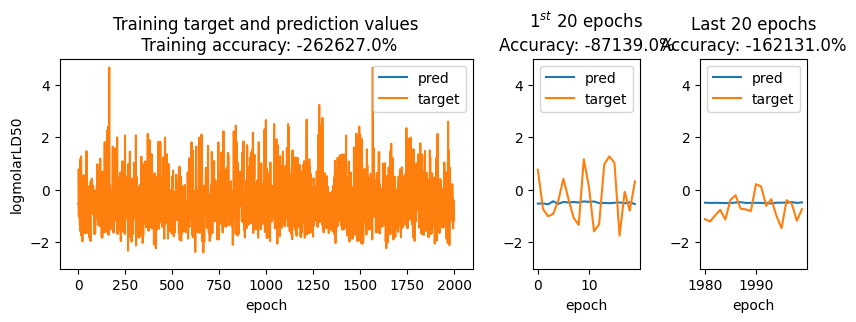

In [132]:
fig = plt.figure(figsize=(10,6))
 
ax1 = plt.subplot2grid(shape=(2, 28), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 28), loc=(0,17), colspan=4)
ax3 = plt.subplot2grid(shape=(2, 28), loc=(0,23), colspan=4)


results[[ 'pred', 'target']].plot(title='Training target and prediction values\n Training accuracy: ' + str(round(training_acc, 2) )+ '%',
                                  xlabel='epoch', ylabel = 'logmolarLD50', ax=ax1, ylim = (ymin, ymax) ) 
results[[ 'pred', 'target']][:20].plot(title="$1^{st}$ 20 epochs\nAccuracy: " + str(round(training_acc_1st_20, 2)) +'%',
                                       xlabel='epoch', ax=ax2, ylim = (ymin, ymax))
results[[ 'pred', 'target']][-20:].plot(title="Last 20 epochs\nAccuracy: " + str(round(training_acc_last_20, 2)) +'%',
                                       xlabel='epoch', ax=ax3, ylim = (ymin, ymax))

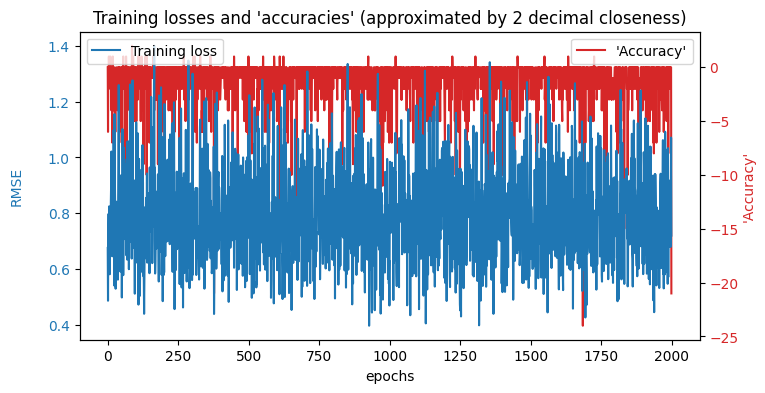

In [133]:
fig, ax1 = plt.subplots(figsize=(8,4))

color1 = 'tab:red'
ax1.set_xlabel('epochs')

ax1.tick_params(axis='y', labelcolor=color1)
sns.lineplot(data=results.accuracy, label="'Accuracy'", color=color1, ax=ax1)
plt.legend(loc='upper right')

ax2 = ax1.twinx() 

color2 = 'tab:blue'
ax1.set_ylabel('RMSE' , color=color2, labelpad=40)
ax2.set_ylabel("'Accuracy'", color=color1, labelpad=30)  

ax2.tick_params(axis='y', labelcolor=color2)
sns.lineplot(data=losses_float, label='Training loss', color=color2, ax=ax2)
plt.legend(loc='upper left')

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

plt.title("Training losses and 'accuracies' (approximated by 2 decimal closeness)")

plt.show()
fig.tight_layout()

In [93]:
X_train1 = np.vstack(X_train['fps'].values)


In [110]:
X_test1 = np.vstack(X_test['fps'].values)

In [104]:
rf= RandomForestRegressor( random_state = 42)
cv = KFold(n_splits=4, shuffle=True, random_state=0)

In [108]:
#scoring = ["r2", "neg_mean_absolute_error"]

In [106]:
cv_results = cross_validate(rf, X_train1, y_train , cv=cv, scoring="neg_mean_absolute_error", return_train_score = True)

In [107]:
cv_results

{'fit_time': array([34.6850872 , 34.39382839, 33.48001432, 34.50741363]),
 'score_time': array([0.04276824, 0.03056264, 0.0308156 , 0.03091288]),
 'test_score': array([-0.47644919, -0.46580426, -0.48258699, -0.49195911]),
 'train_score': array([-0.17862136, -0.18120012, -0.18102253, -0.17538485])}

In [111]:
rf.fit(X_train1, y_train)
y_pred = rf.predict(X_test1)

In [118]:
r2_score(y_test, y_pred)

0.438516598781286

Text(0, 0.5, 'Residual values (logmolar)')

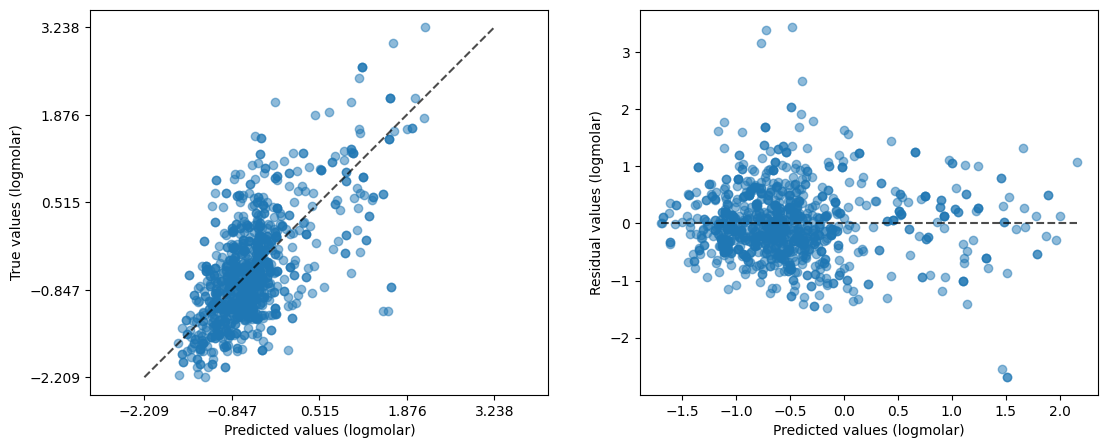

In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(13, 5))

PredictionErrorDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
    ax=axs[0],
)

axs[0].set_xlabel("Predicted values (logmolar)")
axs[0].set_ylabel("True values (logmolar)")

PredictionErrorDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
    ax=axs[1],
)

axs[1].set_xlabel("Predicted values (logmolar)")
axs[1].set_ylabel("Residual values (logmolar)")
